In [1]:
!pip install pycaret

     |████████████████████████████████| 319 kB 5.0 MB/s            
     |████████████████████████████████| 10.4 MB 22.9 MB/s            
     |████████████████████████████████| 25.9 MB 49.3 MB/s            
     |████████████████████████████████| 116 kB 68.0 MB/s            
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 167 kB 47.0 MB/s            
     |████████████████████████████████| 636 kB 62.9 MB/s            
     |████████████████████████████████| 24.2 MB 17.2 MB/s            
     |████████████████████████████████| 6.8 MB 33.8 MB/s            
     |████████████████████████████████| 16.5 MB 39.8 MB/s            
     |████████████████████████████████| 1.0 MB 64.2 MB/s            
     |████████████████████████████████| 184 kB 69.1 MB/s            
     |████████████████████████████████| 271 kB 49.8 MB/s            
     |████████████████████████████████| 14.8 MB 63.1 MB/s            
     |████████████████████████████████| 79 kB 6.0 MB/s    

# Import

In [2]:
from keras.datasets import mnist
from pycaret.datasets import get_data
import numpy as np
import pandas as pd
from scipy.stats import f_oneway, ks_2samp, wasserstein_distance
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
from tqdm import tqdm

# Constants

In [3]:
DATASET_NAMES = [
 'mnist',
 'bank',
 'blood',
 'cancer',
 'credit',
 'diabetes',
 'electrical_grid',
 'employee',
 'heart',
 'heart_disease',
 'hepatitis',
 'income',
 'juice',
 'nba',
 'wine',
 'telescope',
 'titanic',
 'us_presidential_election_results',
 'glass',
 'iris',
 'poker',
 'questions',
 'satellite',
 'CTG'
]

TARGET_NAMES = [
 'digit',
 'deposit',
 'Class',
 'Class',
 'default',
 'Class variable',
 'stabf',
 'left',
 'DEATH',
 'Disease',
 'Class',
 'income >50K',
 'Purchase',
 'TARGET_5Yrs',
 'type',
 'Class',
 'Survived',
 'party_winner',
 'Type',
 'species',
 'CLASS',
 'Next_Question',
 'Class',
 'NSP'
]

# Utils

In [4]:
def get_X_y(dataset_name, target_name):
    if dataset_name == "mnist":
        (X, y), (X_test, y_test) = mnist.load_data()
        X = pd.DataFrame(X.reshape(60000, 28 * 28)).head(1000)
        y = pd.Series(y, name = target_name).head(1000)
    else:    
        df = get_data(dataset_name, verbose=False).dropna(subset=[target_name])
        X, y = pd.get_dummies(df.fillna(df.mean()).drop(target_name, axis=1)), df[target_name]
    return X, y

def standardized_wasserstein_distance(u, v, method="std"):
    u, v = np.array(u), np.array(v)
    numerator = wasserstein_distance(u, v)
    concat = np.concatenate([u, v])
    if method == 'std':
        denominator = np.std(concat)
    elif method == 'minmax':
        denominator = np.max(concat) - np.min(concat)
    elif method == 'mean':
        denominator = max(np.max(concat) - np.mean(concat), np.mean(concat) - np.min(concat))
    elif method == 'median':
        denominator = max(np.min(concat) - np.median(concat), np.median(concat) - np.min(concat))
    elif method == 'iqr':
        denominator = np.diff(np.quantile(concat, [.25, .75]))[0]
    return numerator / denominator if denominator != .0 else .0
    
def get_metric(u, v, metric_name):
    if metric_name == 'ks':
        return 1 - ks_2samp(u, v)[1]
    elif metric_name == 'f':
        return np.nan_to_num(1 - f_oneway(u, v)[1], nan=.0)
    elif metric_name == 'swd':
        return standardized_wasserstein_distance(u, v, 'std')
    else:
        raise
    
def plot_two_cdf(a, b):
    all_values = sorted(set(a) | set(b))
    
    a_cdf = np.vstack(
        [[np.mean(a < v) for v in all_values],
        [np.mean(a <= v) for v in all_values]]
    ).flatten("F")
    
    b_cdf = np.vstack(
        [[np.mean(b < v) for v in all_values],
        [np.mean(b <= v) for v in all_values]]
    ).flatten("F")
    
    all_values = np.repeat(all_values, 2)
    
    return all_values, a_cdf, b_cdf

# Cover image

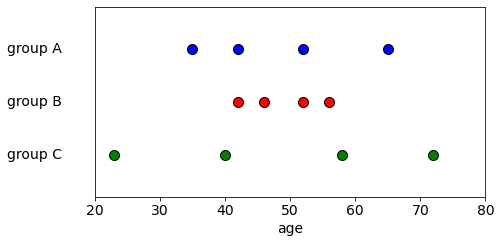

In [5]:
a = [35,42,52,65]
b = [42,46,52,56]
c = [23,40,58,72]

fig, ax = plt.subplots(figsize=(7,3.5))

ax.scatter(a, [2] * len(a), s=100, color="blue", edgecolors="black")
ax.scatter(b, [1] * len(b), s=100, color="red", edgecolors="black")
ax.scatter(c, [0] * len(c), s=100, color="green", edgecolors="black")

ax.text(15, 2, 'group A', va="center", ha="right", fontsize=14)
ax.text(15, 1, 'group B', va="center", ha="right", fontsize=14)
ax.text(15, 0, 'group C', va="center", ha="right", fontsize=14)

ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_xlabel('age', fontsize=14)

ax.set(
    xlim = [20,76],
    xticks = range(20,81,10),
    ylim = [-.8,2.8],
    yticks = []
)

fig.savefig('cover.png', dpi=200, bbox_inches="tight")

# Why p-values won't work

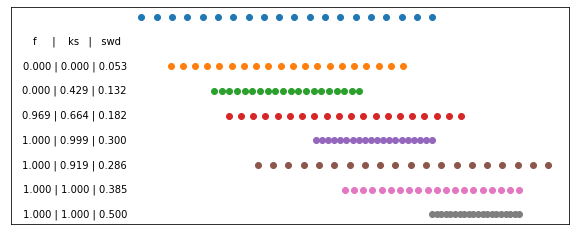

In [6]:
n = 20

fig, ax = plt.subplots(figsize=(10,4))

x0 = np.linspace(0,10,n)

xs = [
    np.linspace(1,9,n),
    np.linspace(2.5,7.5,n),
    
    np.linspace(3,11,n),
    np.linspace(6,10,n),

    np.linspace(4,14,n),
    np.linspace(7,13,n),
    
    np.linspace(10,13,n)
]

ax.scatter(x0, [1] * len(x0))
ax.text(-.5, 0, 'f     |    ks   |   swd  ', va="center", ha="right")

for i, x in enumerate(xs):
    ax.scatter(x, [-i-1] * len(x))
    f = get_metric(x0, x, 'f')
    ks = get_metric(x0, x, 'ks')
    swd = standardized_wasserstein_distance(x0, x, 'minmax')
    out = '{:.3f} | {:.3f} | {:.3f}'.format(f, ks, swd)
    ax.text(-.5, -i-1, out, va="center", ha="right")
    
ax.set_xlim(-4.5,)
ax.set(xticks=[], yticks=[])
fig.savefig('trails_20points.png', dpi=200)

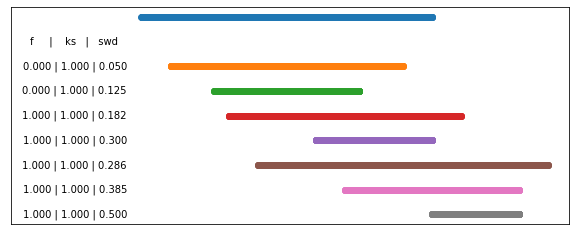

In [7]:
n = 1000

fig, ax = plt.subplots(figsize=(10,4))

x0 = np.linspace(0,10,n)

xs = [
    np.linspace(1,9,n),
    np.linspace(2.5,7.5,n),
    
    np.linspace(3,11,n),
    np.linspace(6,10,n),

    np.linspace(4,14,n),
    np.linspace(7,13,n),
    
    np.linspace(10,13,n)
]

ax.scatter(x0, [1] * len(x0))
ax.text(-.5, 0, 'f     |    ks   |   swd   ', va="center", ha="right")

for i, x in enumerate(xs):
    ax.scatter(x, [-i-1] * len(x))
    f = get_metric(x0, x, 'f')
    ks = get_metric(x0, x, 'ks')
    swd = standardized_wasserstein_distance(x0, x, 'minmax')
    out = '{:.3f} | {:.3f} | {:.3f}'.format(f, ks, swd)
    ax.text(-.5, -i-1, out, va="center", ha="right")
    
ax.set_xlim(-4.5,)
ax.set(xticks=[], yticks=[])
fig.savefig('trails_1000points.png', dpi=200)

# Idea behind Wasserstein distance

In [8]:
from scipy.stats import wasserstein_distance

a = np.array([40.5, 46.3, 47.8])
b = np.array([43.3, 44.7, 51.8])

print(f"a: {a}\nb: {b}")
print(f"\nscipy.stats.wasserstein_distance(a, b): {wasserstein_distance(a, b)}")
print(f"\nnp.mean(np.abs(np.sort(a) - np.sort(b))): {np.mean(np.abs(np.sort(a) - np.sort(b)))}")

a: [40.5 46.3 47.8]
b: [43.3 44.7 51.8]

scipy.stats.wasserstein_distance(a, b): 2.799999999999997

np.mean(np.abs(np.sort(a) - np.sort(b))): 2.799999999999997


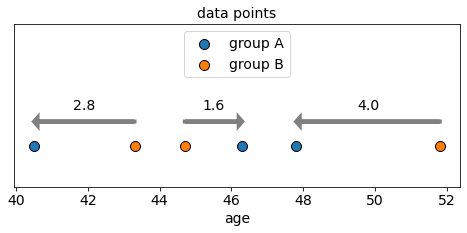

In [9]:
a = np.array([40.5, 46.3, 47.8])
b = np.array([43.3, 44.7, 51.8])

fig, ax = plt.subplots(figsize=(8,3))
plt.subplots_adjust(hspace=.3)

ax.set_title("data points", fontsize=14)
ax.scatter(a, [0] * len(a), s=100, lw=1, edgecolors="black", label="group A")
ax.scatter(b, [0] * len(b), s=100, lw=1, edgecolors="black", label="group B")
for i in range(len(a)):
    diff = a[i] - b[i]
    ax.arrow(b[i], .3, diff, 0, lw=4, color="grey", 
            head_width=0.1, head_length=0.1, length_includes_head=True)
    ax.text(b[i] + diff / 2, .5, round(abs(diff),2), ha="center", va="center", fontsize=14)
ax.tick_params(axis="both", which='major', labelsize=14)
ax.set(yticks=[], ylim=[-.5, 1.5])
ax.set_xlabel("age", fontsize=14)
ax.legend(fontsize=14, loc="upper center")

fig.savefig("data_points.png", bbox_inches="tight", dpi=300)

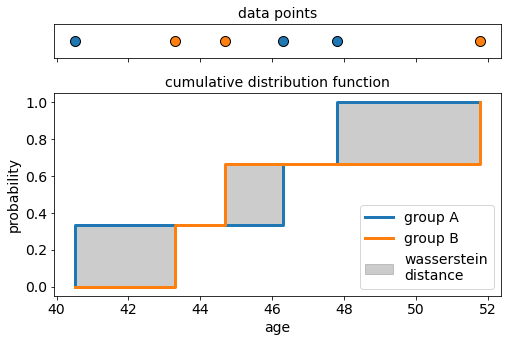

In [10]:
av, a_cdf, b_cdf = plot_two_cdf(a, b)

fig, ax = plt.subplots(2, 1, sharex=True, gridspec_kw={"height_ratios":[1,6]}, figsize=(8,5))
plt.subplots_adjust(hspace=.3)

ax[0].set_title("data points", fontsize=14)
ax[0].scatter(a, [0] * len(a), s=100, lw=1, edgecolors="black")
ax[0].scatter(b, [0] * len(b), s=100, lw=1, edgecolors="black")
ax[0].tick_params(axis='both', which='major', labelsize=14)
ax[0].set(yticks=[])

ax[1].set_title("cumulative distribution function", fontsize=14)
ax[1].plot(av, a_cdf, lw=3, label="group A")
ax[1].plot(av, b_cdf, lw=3, label="group B")
ax[1].fill_between(av, a_cdf, b_cdf, color="grey", alpha=.4, label="wasserstein\ndistance")
ax[1].tick_params(axis='both', which='major', labelsize=14)
ax[1].set_xlabel('age', fontsize=14)
ax[1].set_ylabel('probability', fontsize=14)
ax[1].legend(fontsize=14, loc="lower right")

fig.savefig("cdf_1.png", bbox_inches="tight", dpi=300)

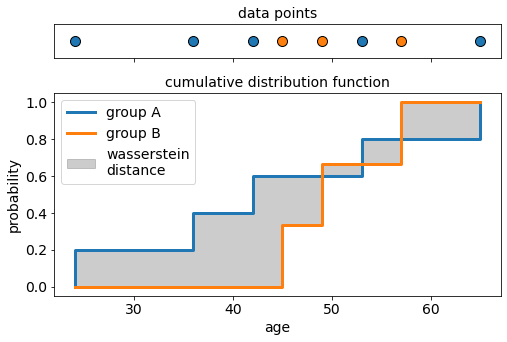

In [11]:
a = np.array([24, 36, 42, 53, 65])
b = np.array([45, 49, 57])

av, a_cdf, b_cdf = plot_two_cdf(a, b)

fig, ax = plt.subplots(2, 1, sharex=True, gridspec_kw={"height_ratios":[1,6]}, figsize=(8,5))
plt.subplots_adjust(hspace=.3)

ax[0].set_title("data points", fontsize=14)
ax[0].scatter(a, [0] * len(a), s=100, lw=1, edgecolors="black")
ax[0].scatter(b, [0] * len(b), s=100, lw=1, edgecolors="black")
ax[0].tick_params(axis='both', which='major', labelsize=14)
ax[0].set(yticks=[])

ax[1].set_title("cumulative distribution function", fontsize=14)
ax[1].plot(av, a_cdf, lw=3, label="group A")
ax[1].plot(av, b_cdf, lw=3, label="group B")
ax[1].fill_between(av, a_cdf, b_cdf, color="grey", alpha=.4, label="wasserstein\ndistance")
ax[1].tick_params(axis='both', which='major', labelsize=14)
ax[1].set_xlabel('age', fontsize=14)
ax[1].set_ylabel('probability', fontsize=14)
ax[1].legend(fontsize=14)

fig.savefig("cdf_2.png", bbox_inches="tight", dpi=300)

# Compare on Datasets

In [12]:
out = pd.DataFrame(index=range(10000), dtype=float)

row_ix = 0

for dataset_name, target_name in tqdm(zip(DATASET_NAMES, TARGET_NAMES)):
    
    X, y = get_X_y(dataset_name, target_name)
        
    out.loc[row_ix:row_ix+len(X.columns)-1, 
        ["dataset_name","feature_name","n_classes", "n_rows"]] = dataset_name, X.columns, len(set(y)), len(X)
        
    for metric_name in ["f", "ks", "swd"]:
        out_tmp = pd.DataFrame()
        for yval in y.unique():
            for col in X.columns:
                out_tmp.loc[yval, col] = get_metric(
                    X.loc[y == yval, col], 
                    X.loc[y != yval, col], 
                    metric_name
                )
        out.loc[row_ix : row_ix + len(X.columns) - 1, metric_name] = out_tmp.mean().to_list()
        
    out.loc[row_ix : row_ix + len(X.columns) - 1, "fimpo"] = \
        CatBoostClassifier(silent=True)\
        .fit(X, y)\
        .feature_importances_
    
    row_ix += len(X.columns)
    
out = out[~out["feature_name"].isna()]
out.to_csv('out.csv', index=False)

0it [00:00, ?it/s]

11501568/11490434 [==============================] - 0s 0us/step


/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Returns
/opt/conda/lib/python3.7/site-packages/scipy/stats/stats.py:3641: F_onewayConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(F_onewayConstantInputWarning())
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1684: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = infer_fill_value(value)
1it [04:45, 285.92s/it]/opt/conda/lib/python

In [13]:
out.groupby("dataset_name").apply(
    lambda d: 
        pd.Series([d["n_classes"].iloc[0], len(d), d["n_rows"].iloc[0]],
            ["n_classes", "n_features", "n_rows"])
)

,n_classes,n_features,n_rows
dataset_name,,,
CTG,3.0,2562.0,2126.0
bank,2.0,51.0,45211.0
blood,2.0,4.0,748.0
cancer,2.0,9.0,683.0
credit,2.0,23.0,24000.0
diabetes,2.0,8.0,768.0
electrical_grid,2.0,12.0,10000.0
employee,2.0,20.0,14999.0
glass,6.0,9.0,214.0


In [14]:
out.describe()

,n_classes,n_rows,f,ks,swd,fimpo
count,6827.000000,6827.00000,6827.000000,6827.000000,6827.000000,6827.000000
mean,3.330160,2603.33265,0.592609,0.096266,0.104993,0.351545
std,2.472996,6727.53681,0.238316,0.274752,0.165880,2.344197
min,2.000000,150.00000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,891.00000,0.318005,0.000000,0.025569,0.000000
50%,2.000000,1340.00000,0.569739,0.000000,0.054401,0.000000
75%,3.000000,2126.00000,0.794663,0.000000,0.087329,0.000096
max,10.000000,99998.00000,1.000000,1.000000,1.724922,61.227048


In [15]:
out.loc[:, ["dataset_name", "feature_name", "f", "ks", "swd", "fimpo"]].sample(5)

,dataset_name,feature_name,f,ks,swd,fimpo
5837,CTG,SegFile_CTG1137.txt,0.318005,0.0,0.025569,0.000000
1839,nba,Name_Kosta Koufos,0.565953,0.0,0.044067,0.000000
2218,nba,Name_Shareef Abdur-Rahim,0.565953,0.0,0.044067,0.000000
4718,CTG,SegFile_CTG0018.txt,0.720845,0.0,0.092635,0.027773
2044,nba,Name_Nolan Smith,0.798543,0.0,0.071944,0.000000


In [16]:
out_corr = out.loc[:,["dataset_name", "f", "ks", "swd", "fimpo"]].groupby('dataset_name').apply(lambda d: d.corr().fillna(0).drop('fimpo')['fimpo'])
out_corr.style.highlight_max(color="darkblue", axis = 1)

fimpo,f,ks,swd
dataset_name,,,
CTG,0.079776,0.259777,0.408793
bank,0.113973,0.236498,0.683330
blood,-0.627339,-0.627339,-0.380736
cancer,0.000000,0.000000,0.655223
credit,0.040862,0.103241,0.097218
diabetes,0.486453,0.520709,0.940234
electrical_grid,0.721062,0.725183,0.988939
employee,0.143750,0.478244,0.887292
glass,0.516646,0.730219,0.500001


In [17]:
out_corr_mean = out_corr.mean().sort_values(ascending=False)
out_corr_mean

fimpo
swd    0.625534
ks     0.395324
f      0.196890
dtype: float64